## Scaling Laws in Classical Statistics

Scaling laws appeared first in simple statistical estimation problems.

### Mean Estimation Example

When estimating a mean from n i.i.d. samples:
- True mean: $\mu$
- Sample mean: $\hat{\mu} = \frac{1}{n}\sum_i x_i$
- MSE: $E[(\hat{\mu} - \mu)^2] = \frac{\sigma^2}{n}$

In log-log space: $\log(\text{error}) = -\log(n) + \text{const}$

This is a **power law** with exponent -1.

### Why Most Classical Models Have 1/n Scaling

This isn't special to mean estimation — it's a fundamental property of **parametric estimation** with i.i.d. data.

**The Core Argument**

When you average n independent "pieces of information":

$$\text{Var}\left(\frac{1}{n}\sum_{i=1}^n X_i\right) = \frac{1}{n^2} \cdot n \cdot \sigma^2 = \frac{\sigma^2}{n}$$

The $n^2$ in the denominator comes from squaring the $1/n$ factor, but you only get $n$ terms of variance (since covariances are zero for independent samples). This gives you $1/n$.

**Cramér-Rao Lower Bound**

There's a **fundamental limit** on how well any unbiased estimator can do:

$$\text{Var}(\hat{\theta}) \geq \frac{1}{n \cdot I(\theta)}$$

where $I(\theta)$ is the Fisher information. Notice the $1/n$ — this is the best you can possibly achieve.

**Maximum Likelihood Estimators**

MLEs are "asymptotically efficient" — they achieve this $1/n$ bound as $n \to \infty$. This applies to:
- Linear regression coefficients
- Logistic regression
- Most parametric models you'd call "classical"

### Takeaway

The $1/n$ scaling is the **statistical speed limit** for parametric estimation. It emerges whenever:
1. You have i.i.d. samples
2. Fixed model complexity (finite parameters)
3. Regularity conditions hold

This is why modern deep learning scaling laws (like Chinchilla) are interesting — they show **different exponents** because you're simultaneously scaling model size and data, entering a fundamentally different regime.


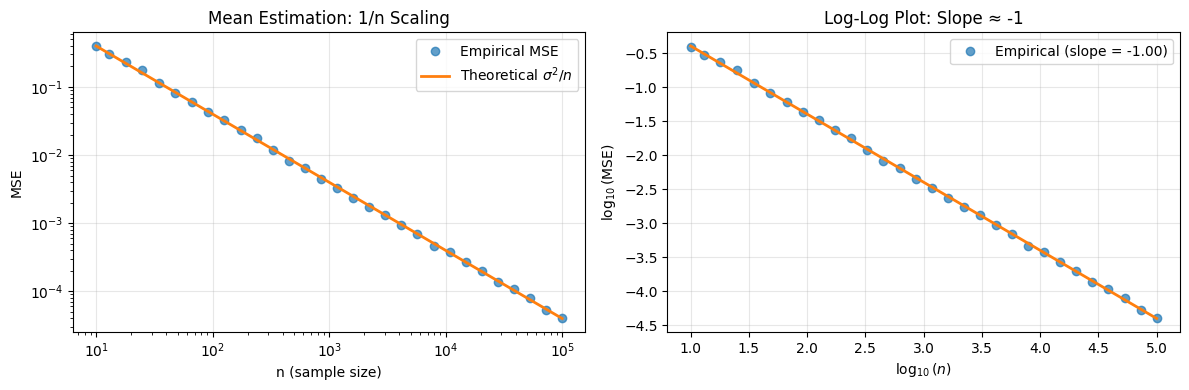

Fitted slope: -1.002 (theoretical: -1.0)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

sigma = 2.0
mu = 5.0
n_values = np.logspace(1, 5, 30).astype(int)
n_trials = 1000

empirical_mse = []
for n in n_values:
    errors = []
    for _ in range(n_trials):
        samples = np.random.normal(mu, sigma, n)
        mu_hat = samples.mean()
        errors.append((mu_hat - mu)**2)
    empirical_mse.append(np.mean(errors))

theoretical_mse = sigma**2 / n_values

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].loglog(n_values, empirical_mse, 'o', label='Empirical MSE', alpha=0.7)
axes[0].loglog(n_values, theoretical_mse, '-', label=r'Theoretical $\sigma^2/n$', linewidth=2)
axes[0].set_xlabel('n (sample size)')
axes[0].set_ylabel('MSE')
axes[0].set_title('Mean Estimation: 1/n Scaling')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

log_n = np.log10(n_values)
log_mse_emp = np.log10(empirical_mse)
log_mse_theo = np.log10(theoretical_mse)

axes[1].plot(log_n, log_mse_emp, 'o', label='Empirical', alpha=0.7)
axes[1].plot(log_n, log_mse_theo, '-', label=r'Theoretical $\sigma^2/n$', linewidth=2, color='C1')
axes[1].set_xlabel(r'$\log_{10}(n)$')
axes[1].set_ylabel(r'$\log_{10}(\mathrm{MSE})$')
axes[1].set_title('Log-Log: Slope = -1')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



### Linear Regression: Same 1/n Scaling

For linear regression $y = X\beta + \varepsilon$ with $\varepsilon \sim N(0, \sigma^2)$, the OLS estimator has:

$$\text{Var}(\hat{\beta}) = \sigma^2 (X^T X)^{-1}$$

For well-behaved $X$, this gives $\|\hat{\beta} - \beta\|^2 \sim O(p/n)$ — still 1/n scaling, but the constant depends on the number of parameters $p$.


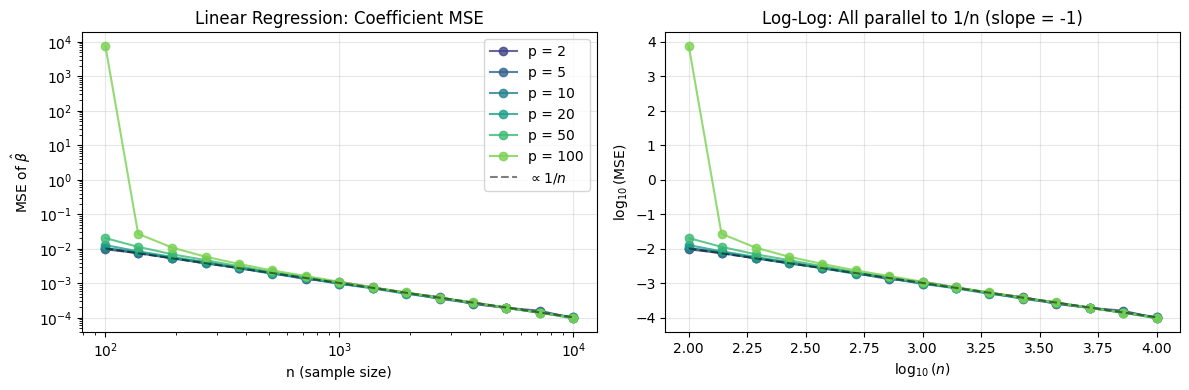

In [10]:
from sklearn.linear_model import LinearRegression, LogisticRegression

np.random.seed(42)

def run_linreg_experiment(p, n_values, n_trials=500):
    beta_true = np.random.randn(p)
    sigma = 1.0
    
    mse_list = []
    for n in n_values:
        errors = []
        for _ in range(n_trials):
            X = np.random.randn(n, p)
            y = X @ beta_true + sigma * np.random.randn(n)
            
            model = LinearRegression(fit_intercept=False)
            model.fit(X, y)
            beta_hat = model.coef_
            
            errors.append(np.mean((beta_hat - beta_true)**2))
        mse_list.append(np.mean(errors))
    return np.array(mse_list)

n_values = np.logspace(2, 4, 15).astype(int)
dims = [2, 5, 10, 20, 50, 100]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(dims)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

results = {}
for p, color in zip(dims, colors):
    mse = run_linreg_experiment(p, n_values, n_trials=300)
    results[p] = mse
    axes[0].loglog(n_values, mse, 'o-', color=color, label=f'p = {p}', alpha=0.8)

log_n = np.log10(n_values)
slope, intercept = np.polyfit(log_n, np.log10(results[2]), 1)

n_ref = np.array([100, 10000], dtype=float)
axes[0].loglog(n_ref, 10**intercept * n_ref**slope, 'k--', alpha=0.5, linewidth=1.5, label=r'$\propto 1/n$')
axes[0].set_xlabel('n (sample size)')
axes[0].set_ylabel(r'MSE of $\hat{\beta}$')
axes[0].set_title('Linear Regression: Coefficient MSE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for p, color in zip(dims, colors):
    log_mse = np.log10(results[p])
    axes[1].plot(log_n, log_mse, 'o-', color=color, label=f'p = {p}', alpha=0.8)
axes[1].plot(log_n, slope * log_n + intercept, 'k--', alpha=0.5, linewidth=1.5, label=r'$\propto 1/n$')
axes[1].set_xlabel(r'$\log_{10}(n)$')
axes[1].set_ylabel(r'$\log_{10}(\mathrm{MSE})$')
axes[1].set_title('Log-Log: All parallel to 1/n (slope = -1)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Logistic Regression: Also 1/n

The 1/n scaling isn't limited to linear regression — it applies to any MLE under regularity conditions. Here's logistic regression:


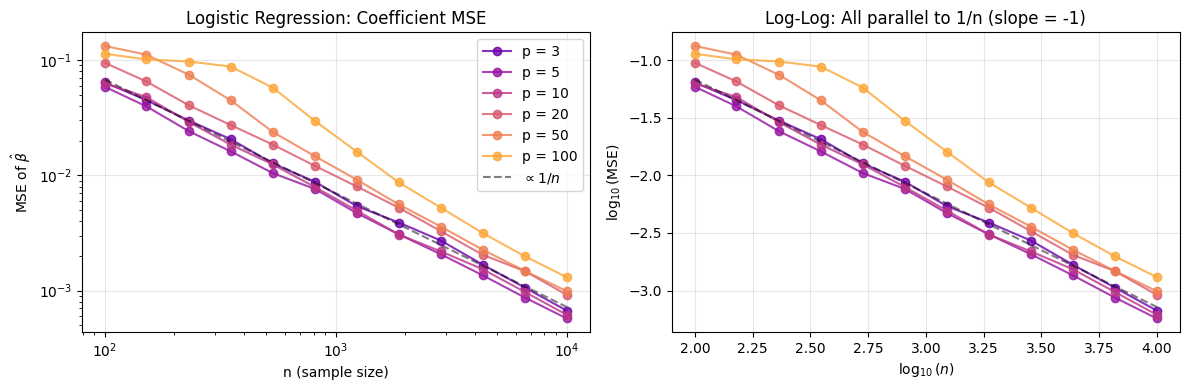

In [11]:
import warnings
warnings.filterwarnings('ignore')

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def run_logreg_experiment(p, n_values, n_trials=200):
    beta_true = np.random.randn(p) * 0.5
    
    mse_list = []
    for n in n_values:
        errors = []
        for _ in range(n_trials):
            X = np.random.randn(n, p)
            prob = sigmoid(X @ beta_true)
            y = (np.random.rand(n) < prob).astype(int)
            
            if len(np.unique(y)) < 2:
                continue
                
            model = LogisticRegression(fit_intercept=False, solver='lbfgs', max_iter=1000)
            model.fit(X, y)
            beta_hat = model.coef_.flatten()
            
            errors.append(np.mean((beta_hat - beta_true)**2))
        if errors:
            mse_list.append(np.mean(errors))
        else:
            mse_list.append(np.nan)
    return np.array(mse_list)

n_values_logreg = np.logspace(2, 4, 12).astype(int)
dims_logreg = [3, 5, 10, 20, 50, 100]
colors_logreg = plt.cm.plasma(np.linspace(0.2, 0.8, len(dims_logreg)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

results_log = {}
for p, color in zip(dims_logreg, colors_logreg):
    mse = run_logreg_experiment(p, n_values_logreg, n_trials=200)
    results_log[p] = mse
    mask = ~np.isnan(mse)
    axes[0].loglog(n_values_logreg[mask], mse[mask], 'o-', color=color, label=f'p = {p}', alpha=0.8)

log_n = np.log10(n_values_logreg)
mse_3 = results_log[3]
mask_3 = ~np.isnan(mse_3)
slope, intercept = np.polyfit(log_n[mask_3], np.log10(mse_3[mask_3]), 1)

n_ref = np.array([100, 10000], dtype=float)
axes[0].loglog(n_ref, 10**intercept * n_ref**slope, 'k--', alpha=0.5, linewidth=1.5, label=r'$\propto 1/n$')
axes[0].set_xlabel('n (sample size)')
axes[0].set_ylabel(r'MSE of $\hat{\beta}$')
axes[0].set_title('Logistic Regression: Coefficient MSE')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for p, color in zip(dims_logreg, colors_logreg):
    mse = results_log[p]
    mask = ~np.isnan(mse)
    axes[1].plot(log_n[mask], np.log10(mse[mask]), 'o-', color=color, label=f'p = {p}', alpha=0.8)
axes[1].plot(log_n, slope * log_n + intercept, 'k--', alpha=0.5, linewidth=1.5, label=r'$\propto 1/n$')
axes[1].set_xlabel(r'$\log_{10}(n)$')
axes[1].set_ylabel(r'$\log_{10}(\mathrm{MSE})$')
axes[1].set_title('Log-Log: All parallel to 1/n (slope = -1)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Why Are LLM Scaling Laws Different?

Classical models: $\text{Error} \propto n^{-1}$ (slope = -1)

LLMs (Chinchilla): $\text{Loss} \propto D^{-0.095}$ for data, $N^{-0.076}$ for parameters

**The exponents are ~10x smaller!** Why?

### 1. Fixed vs. Scaling Model Complexity

Classical theory assumes **fixed p, varying n**. In deep learning, we scale **both** model size and data together. You never reach the "n >> p" asymptotic regime where 1/n kicks in.

### 2. Finite vs. Infinite-Dimensional Targets

Classical: Estimate a **finite-dimensional parameter** θ ∈ ℝᵖ

LLMs: Approximate an **infinite-dimensional distribution** P(next token | context)

For infinite-dimensional problems, convergence rates depend on the **smoothness** of what you're approximating. Language is complex → slow rates.

### 3. The Bias-Variance Decomposition

Classical 1/n is pure **variance** reduction (assuming correct model).

Neural nets have both:
- **Variance**: reduced by more data (~1/n in principle)
- **Bias/Approximation error**: reduced by bigger models

When you scale both together optimally, you get a slower combined rate.

### 4. Power-Law Structure in Language

Language itself has power-law statistics (Zipf's law). "Easy" patterns are learned first; each doubling of compute captures increasingly rare/subtle patterns — diminishing returns built into the task.


## Reproducing Chinchilla (Small Scale)
